In [1]:
# object detector
# takes any image and predicts center of hand
# give that to joint predictor so hand can be cropped

In [53]:

import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import json
from IPython.display import SVG
from skimage import data
from skimage.transform import resize
from scipy import ndimage
from scipy import misc
import imageio
%matplotlib inline

In [54]:
annotations = json.load(open("hand_annotations_new.json", 'r'))
num_images = len(annotations)

In [57]:
scale=.4
width = int(405*scale) # 162 # 243 # 405
height = int(720*scale) # 288 # 32 # 720
X = np.ndarray([num_images,height, width, 3])
for i, image in enumerate(annotations):
    image = imageio.imread(image)
    resized_image = resize(image, [height, width])  
    X[i] = resized_image

C:\Users\katkh\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [59]:
Y = np.zeros([num_images, 4])
for i, image in enumerate(annotations):
    target = np.reshape(annotations[image], 4)
    Y[i] = np.multiply(target, scale)

In [60]:
# split into inputs and targets
split = round(num_images*.7)
indices = np.random.choice(num_images, num_images, replace=False)
X = X[indices]
Y= Y[indices]
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:num_images]
Y_test = Y[split:num_images]

In [61]:
# tf.losses.mean_pairwise_squared_error
def loss (y_true, y_pred):
    #return np.sqrt((y_true[0] - y_pred[0])**2 + (y_true[1] - y_pred[1])**2)
    return tf.norm(y_true-y_pred, ord='euclidean')

In [76]:
def hand_detector():
    inp = tf.keras.Input(shape=[height,width,3],dtype=tf.float32) 
   # pool1 = tf.keras.layers.AveragePooling2D(2)(inp)
#     conv1 = tf.keras.layers.Conv2D(64, 9)(pool1)
#     pool2 = tf.keras.layers.AveragePooling2D(2)(conv1)
#     conv2 = tf.keras.layers.Conv2D(32, 9)(pool1)
#     pool2 = tf.keras.layers.AveragePooling2D(2)(conv2)
#     conv3 = tf.keras.layers.Conv2D(16, 7)(pool2)
#     pool3 = tf.keras.layers.AveragePooling2D(2)(conv3)
    flat = tf.keras.layers.Flatten()(inp)
    dense_1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(flat)
    dense_2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)(dense_1)
    dense_3 = tf.keras.layers.Dense(32, activation=tf.nn.relu)(dense_2)
    dense_4 = tf.keras.layers.Dense(16, activation=tf.nn.relu)(dense_3)
    output = tf.keras.layers.Dense(4, activation=tf.nn.relu)(dense_4)
    model = tf.keras.Model(inputs=inp, outputs=output)
    return model

In [77]:
def hand_detector_conv():
    inp = tf.keras.Input(shape=[height,width,3],dtype=tf.float32) 
    net = tf.keras.layers.AveragePooling2D(2)(inp)
    net = tf.keras.layers.Conv2D(64, 9)(net)
    net = tf.keras.layers.AveragePooling2D(2)(net)
    net = tf.keras.layers.Conv2D(32, 5)(net)
    flat = tf.keras.layers.Flatten()(net)
    dense_1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(flat)
    dense_2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)(dense_1)
    output = tf.keras.layers.Dense(4, activation=tf.nn.relu)(dense_2)
    model = tf.keras.Model(inputs=inp, outputs=output)
    return model

In [78]:

model = hand_detector()
print ("Hand Detector")
model.summary()

model1 = hand_detector_conv()
print ("Hand Detector Conv")
model1.summary()

Hand Detector
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 288, 162, 3)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 139968)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8958016   
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 68     

In [92]:
model.compile('adam', loss)
model.fit(x=X_train, y=Y_train, epochs=200, verbose=0)


In [93]:
Yhat_test = model.predict(X_test)

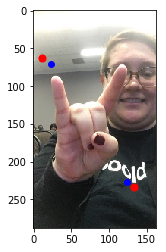

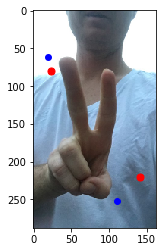

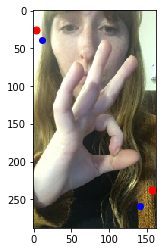

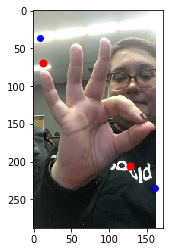

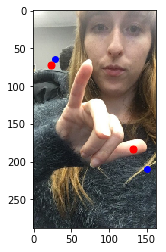

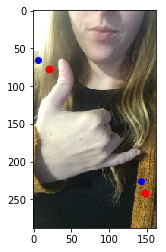

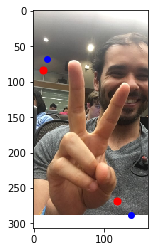

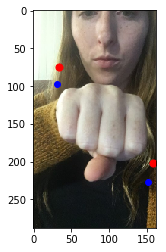

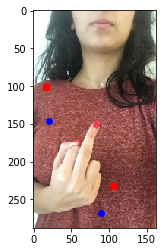

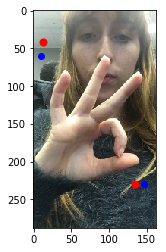

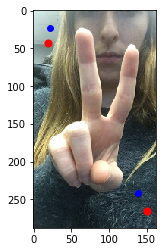

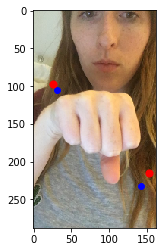

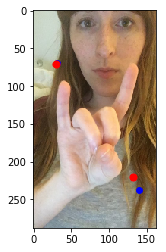

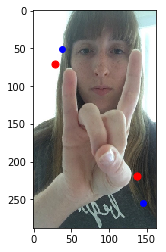

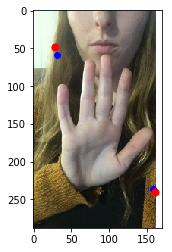

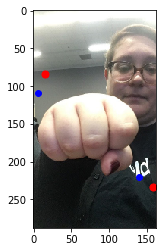

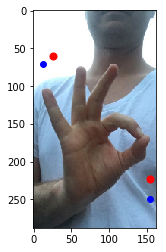

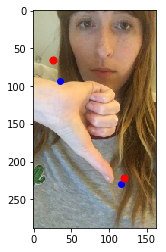

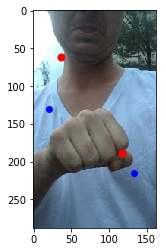

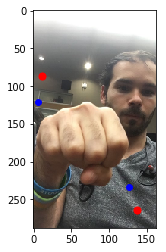

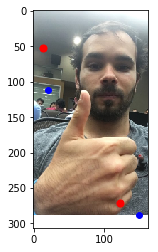

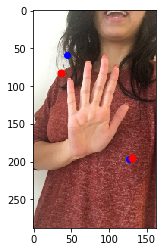

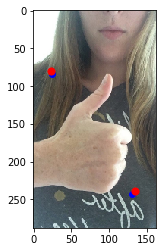

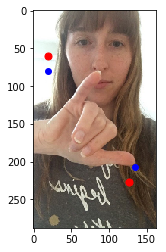

In [94]:
for i, image in enumerate(X_test):
    plt.imshow(image)
    plt.scatter(Y_test[i][0], Y_test[i][1], s=35, c='blue')
    plt.scatter(Y_test[i][2], Y_test[i][3], s=35, c='blue')
    plt.scatter(Yhat_test[i][0], Yhat_test[i][1], c='red', s=50)
    plt.scatter(Yhat_test[i][2], Yhat_test[i][3], c='red', s=50)
    plt.show()